# Approximate Bayesian Computation

Think Bayes, Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install libraries

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
# Get utils.py

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py

In [3]:
from utils import set_pyplot_params
set_pyplot_params()

In this chapter I describe my solution to a problem posed by a patient
with a kidney tumor. I think the problem is important and relevant to
patients with these tumors and doctors treating them.

And I think the solution is interesting because, although it is a
Bayesian approach to the problem, the use of Bayes's theorem is
implicit. I present the solution and my code; at the end of the example I will explain the Bayesian part.

TODO: Update this intro

## The Kidney Tumor Problem

I am a frequent reader and occasional contributor to the online
statistics forum at <http://reddit.com/r/statistics>. 
In November 2011, I read the following message:

> "I have Stage IV Kidney Cancer and am trying to determine if the cancer formed before I retired from the military. ... Given the dates of retirement and detection is it possible to determine when there was a 50/50 chance that I developed the disease? Is it possible to determine the probability on the retirement date? My tumor was 15.5 cm x 15 cm at detection. Grade II."

I contacted the author of the message to get more information; I
learned that veterans get different benefits if it is "more likely than not" that a tumor formed while they were in military service (among other considerations).

Because renal tumors grow slowly, and often do not cause symptoms, they are sometimes left untreated. As a result, doctors can observe the rate of growth for untreated tumors by comparing scans from the same patient at different times. Several papers have reported these growth rates.

For my analysis I used data from a paper by [Zhang et al](https://pubs.rsna.org/doi/full/10.1148/radiol.2501071712). 
They report growth rates in two forms:

* Volumetric doubling time, which is the time it would take for a tumor to double in size.

* Reciprocal doubling time (RDT), which is the number of doublings per year.

The next section shows how we work with these growth rates.

## A Growth Model

We'll start with a simple model of tumor growth and gradually add complications.

For the simple model, we'll assume

* Tumors grow with a constant doubling time, and 

* They are roughly spherical in shape.

And I'll define three points in time:

* `t0` is when the tumor formed (soon I'll be more precise about what that means).

* `t1` is when my correspondent retired.

* `t2` is when the tumor was detected.

I learned from my correspondent that the time between `t1` and `t2` was 3291 days (about 9 years).

In [4]:
interval = 3291      # days

As an example, let's assume that the diameter of the tumor at `t1` was 1 cm.

In [5]:
d1 = 1      # cm

The following function computes the volume of a sphere with a given diameter.

In [6]:
import numpy as np

def calc_vol(diameter):
    """Converts a diameter to a volume.

    V = 4/3 pi (d/2)^3
    """
    factor = 4 * np.pi / 3
    return factor * (diameter/2.0)**3

So if we assume that the tumor is spherical, we can compute its volume at `t1`.

In [7]:
v1 = calc_vol(d1)
v1

0.5235987755982988

The median volume doubling time reported by Zhang et al. is 811 days.

In [8]:
median_doubling_time = 811       # days

So we can compute the number of doublings that would have happened in the given interval at the median growth rate.

In [9]:
doublings = interval / median_doubling_time
doublings

4.057953144266338

Given `v1` and the number of doublings, we can compute the volume at `t2`.

In [10]:
v2 = v1 * 2**doublings
v2

8.720958899498342

The following function computes the diameter of a sphere with the given volume.

In [11]:
def calc_diameter(volume):
    """Converts a volume to a diameter.

    d = 2r = 2 * (3/4/pi V)^1/3
    """
    factor = 3 / np.pi / 4
    return 2 * (factor * volume)**(1/3)

So we can compute the diameter of the tumor at `t2`:

In [12]:
d2 = calc_diameter(v2)
d2

2.553809740864908

If the diameter of the tumor was 1 cm at `t1`, and it grew at the median rate, the diameter would be about 2.6 cm at `t2`.

This example demonstrates the growth model, but it doesn't answer the question my correspondent posed.

## Working Backwards

We can get a partial answer by starting at the end and working backwards; that is, given that the diameter of the tumor was 15.5 cm at `t2`, how big would it have been at `t1`, assuming that it grew at the median rate?

Here's the volume at `t2`:

In [13]:
d2 = 15.5
v2 = calc_vol(d2)
v2

1949.816390481115

Since we already know the number of doublings in the interval, we can compute the volume at `t1` like this:

In [14]:
v1 = v2 / 2**doublings
v1

117.06527762172266

And given `v1`, we can compute the corresponding diameter:

In [15]:
d1 = calc_diameter(v1)
d1

6.06936364599759

The diameter at `t1` would have been about 6 cm.
We can conclude:

* If the tumor grew at the median rate, it must have formed prior to `t1`, or

* If it formed after `t1`, it must have grown substantially faster than the median rate.

Based on these results, I concluded that is "more likely than not" that the tumor formed prior to the date of discharge, and on behalf of my correspondent, I wrote a letter to the Veterans' Benefit Administration.

Later I told a friend, who is an oncologist, about my results. 
He was surprised by the growth rates I found and by what they imply about the ages of these tumors. 
He suggested that the results might be interesting to researchers and doctors.

But in order to make them useful, I needed a more general model of the
relationship between age and size.

## A More General Model

Given the size of a tumor at time of diagnosis, we would like to know the distribution of its age.

To find it, we'll run simulations of tumor growth to get the distribution of size conditioned on age. 
Then we'll use a Bayesian approach to get the distribution of age conditioned on size.

The simulation starts with a small tumor and runs these steps:

1.  Choose a value from the distribution of growth rates.

2.  Compute the size of the tumor at the end of an interval.

3.  Repeat until the tumor exceeds the maximum relevant size.

So the first thing we need is the distribution of growth rates.

## Distribution of Growth Rates

Using the figures in the paper by Zhange et al., I created an array, `rdt_sample`, that contains estimated values of RDT for the 53 patients in the study.

Again, RDT stands for "reciprocal doubling time", which is in doublings per year.
So if `rdt=1`, a tumor would double in volume in one year.
If `rdt=2`, it would double twice; that is, the volume would quadruple.
And if `rdt=-1`, it would halve in volume.

In [16]:
# Data from the histogram in Figure 3

import numpy as np
from empiricaldist import Pmf

counts = [2, 29, 11, 6, 3, 1, 1]
rdts = np.arange(-1, 6) + 0.01
pmf_rdt = Pmf(counts, rdts)
pmf_rdt.normalize()

53

In [17]:
# Data from the scatter plot in Figure 4

rdts = [5.089,  3.572,  3.242,  2.642,  1.982,  1.847,  1.908,  1.798,
        1.798,  1.761,  2.703, -0.416,  0.024,  0.869,  0.746,  0.257,
        0.269,  0.086,  0.086,  1.321,  1.052,  1.076,  0.758,  0.587,
        0.367,  0.416,  0.073,  0.538,  0.281,  0.122, -0.869, -1.431,
        0.012,  0.037, -0.135,  0.122,  0.208,  0.245,  0.404,  0.648,
        0.673,  0.673,  0.563,  0.391,  0.049,  0.538,  0.514,  0.404,
        0.404,  0.33,  -0.061,  0.538,  0.306]

rdt_sample = np.array(rdts)
len(rdt_sample)

53

We can use the sample of RDTs to estimate the PDF of the distribution.

In [18]:
from utils import kde_from_sample

qs = np.linspace(-2, 6, num=201)
kde_rdt = kde_from_sample(rdt_sample, qs)

In [19]:
1 / kde_rdt.median() * 365

651.7857142857142

`kde_rdt` is a `Pmf` object; we can use it to estimate the CDF of the distribution, too.

In [20]:
cdf_rdt = kde_rdt.make_cdf()

Here's what it looks like.

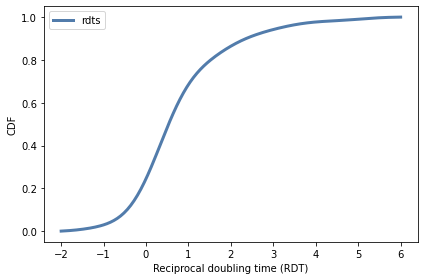

In [21]:
from utils import decorate

cdf_rdt.plot(label='rdts')

decorate(xlabel='Reciprocal doubling time (RDT)',
         ylabel='CDF')

To generate a random value from the distribution, we can use `Pmf.choice`:

In [22]:
np.random.seed(18)

In [23]:
kde_rdt.choice()

0.9199999999999999

To generate a sequence of random values, I'll use the following generator function.
If you are not familiar with generator functions in Python, you can [read about them here](https://wiki.python.org/moin/Generators).


In [24]:
def uncorrelated_generator(pmf, rho=None):
    """Generates a sequence of values from pmf.

    pmf: distribution to choose from
    rho: ignored
    """
    while True:
        yield pmf.choice()

For the current version of the model, using a generator function isn't really necessary, but for the next version it will turn out to be convenient.

When we call `uncorrelated_generator`, it returns a generator object:

In [25]:
rdt_gen = uncorrelated_generator(kde_rdt)
rdt_gen

<generator object uncorrelated_generator at 0x7fc15148d270>

The generator behaves like a iterator, so we can use it in a `for` loop, or we can use `next` to get the next value.

For example, here's a function that takes a generator and generates a sample with the given number of values:

In [26]:
def generate_sample(gen, size=1000):
    """Get a sample from a generator.
    
    gen: generator
    size: sample size
    
    returns: list
    """
    return [next(gen) for _ in range(size)]

And we can call it like this.

In [27]:
sample = generate_sample(rdt_gen)

Here's a quick test to confirm that it works:

In [28]:
from empiricaldist import Cdf

cdf_sample = Cdf.from_seq(sample)

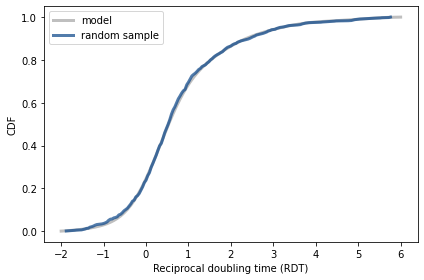

In [29]:
cdf_rdt.plot(label='model', color='C5')
cdf_sample.plot(label='random sample')

decorate(xlabel='Reciprocal doubling time (RDT)',
         ylabel='CDF')

With that, we have everything we need to simulate the growth of a tumor.

## Simulation

For the initial diameter I chose 0.3 cm, because carcinomas smaller than that are less likely to be invasive and less likely to have the blood supply needed for rapid growth (see [this page on carcinoma](http://en.wikipedia.org/wiki/Carcinoma_in_situ)).

I chose an interval of 245 days (about 8 months) because that is the
median time between measurements in the data source.

For the maximum diameter I chose 20 cm. 


In [30]:
interval = 245 / 365      # year
min_diameter = 0.3        # cm
max_diameter = 20         # cm

In the data source, the range of observed sizes is 1.0 to 12.0 cm, so we are extrapolating beyond the observed range at each end, but not by far.

I'll use `calc_vol` to compute the initial and maximum volumes:

In [31]:
v0 = calc_vol(min_diameter)
vmax = calc_vol(max_diameter)
v0, vmax

(0.014137166941154066, 4188.790204786391)

The following function runs the simulation.

In [32]:
import pandas as pd

def simulate_growth(rdt_gen):
    """Simulate the growth of a tumor.
    
    rdt_gen: generator that yields RDT
    
    returns: DataFrame
    """
    age = 0
    volume = v0
    res = []
    
    for rdt in rdt_gen:
        res.append((age, volume))
        if volume > vmax:
            break

        age += interval 
        doublings = rdt * interval
        volume *= 2**doublings
        
    columns = ['age', 'volume']
    sim = pd.DataFrame(res, columns=columns)
    sim['diameter'] = calc_diameter(sim['volume'])
    return sim

`simulate_growth` takes as a parameter a generator that yields reciprocal doubling times (RDT).

It initializes the age and volume of the tumor, then runs a loop that simulates one interval at a time.

Each time through the loop, it checks the volume of the tumor and exits when it exceeds `vmax`.

Then it updates `age` and `volume`.  Since `rdt` is in doublings per year, we multiply by `interval` to get compute the number of doublings during each interval.

At the end of the loop, `simulate_growth` puts the results in a `DataFrame` and computes the diameter that corresponds to each volume.

Here's how we call this function:

In [33]:
np.random.seed(17)

In [34]:
rdt_gen = uncorrelated_generator(kde_rdt)
sim = simulate_growth(rdt_gen)

Here are the results for the first few intervals:

In [35]:
sim.head()

,age,volume,diameter
0,0.000000,0.014137,0.300000
1,0.671233,0.014949,0.305635
2,1.342466,0.019763,0.335441
3,2.013699,0.018690,0.329256
4,2.684932,0.014137,0.300000


And the last few intervals.

In [36]:
sim.tail()

,age,volume,diameter
41,27.520548,502.089669,9.861150
42,28.191781,379.790894,8.984943
43,28.863014,1882.067427,15.318357
44,29.534247,2887.563277,17.667603
45,30.205479,4953.618273,21.149883


The simulation is based on the assumption that the growth rate is
chosen independently during each interval, so it does not depend on age, size, or growth rate during previous intervals.

In Section xxx I review these assumptions and consider more detailed models. 
But first let's look at some examples.
To show the results graphically, I'll run 101 simulations:

In [37]:
np.random.seed(17)

In [38]:
rdt_gen = uncorrelated_generator(kde_rdt)
sims = [simulate_growth(rdt_gen) for _ in range(101)]

And plot the results.

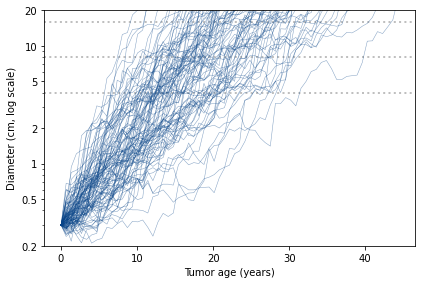

In [39]:
import matplotlib.pyplot as plt

diameters = [4, 8, 16]
for diameter in diameters:
    plt.axhline(diameter,
                color='C5', linewidth=2, linestyle='dotted')

for sim in sims:
    plt.plot(sim['age'], sim['diameter'],
             color='C0', linewidth=0.5, alpha=0.5)
    
decorate(xlabel='Tumor age (years)',
         ylabel='Diameter (cm, log scale)',
         ylim=[0.2, 20],
         yscale='log')

yticks = [0.2, 0.5, 1, 2, 5, 10, 20]
plt.yticks(yticks, yticks);

In this figure, each thin, solid line shows the simulated growth of a tumor over time, with diameter on a log scale.
The dotted lines are at 4, 8, and 16 cm.

By reading across the dotted lines, you can get a sense of the distribution of age at each size.
For example, reading across the top line, we see that a 16 cm tumor might be as young as 10 years or as old as 40 years, but it is most likely to be between 15 and 30.

To compute this distribution more precisely, we can interpolate the growth curves to see when each one passes through a given size.
The following function takes the results of the simulations and returns the age when each tumor reached a given diameter.

In [40]:
from scipy.interpolate import interp1d
from empiricaldist import Pmf

def interpolate_ages(sims, diameter):
    """Interpolate the age when each tumor reached a given size.
    
    sims: sequence of DataFrames
    diameter: float
    
    returns: list of ages
    """
    ages = []
    for sim in sims:
        interp = interp1d(sim['diameter'], sim['age'])
        age = interp(diameter)
        ages.append(float(age))
    return ages

The following figure shows the distribution of ages for tumors with diameters 4, 8, and 16 cm.

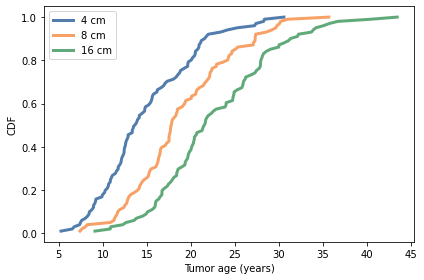

In [41]:
for diameter in diameters:
    ages = interpolate_ages(sims, diameter)
    cdf = Cdf.from_seq(ages)
    cdf.plot(label=f'{diameter} cm')
    
decorate(xlabel='Tumor age (years)',
         ylabel='CDF')

For a tumor 16 cm in diameter, the median age is about 21 years; the 90% credible interval is between 13 and 34 years.

In [42]:
print(cdf.median(), cdf.credible_interval(0.9))

21.601211412918516 [13.55775098 34.2009248 ]


These results are consistent with the simple model; it is unlikely that a tumor of this size is less than 9 years old.

## Serial Correlation

The results so far are based on a number of modeling decisions; let's
review them and consider which ones are the most likely sources of
error:

* To convert from linear measure to volume, we assume that tumors are approximately spherical. This assumption is probably fine for tumors up to a few centimeters, but not for very large tumors.

* The distribution of growth rates is estimated on the basis of only 53 patients. A larger sample might yield a different distribution.

* The growth model does not take into account tumor subtype or grade; this assumption is consistent with the findings of Zhang et al; they conclude: "Growth rates in renal tumors of different sizes, subtypes and grades represent a wide range and overlap substantially." But with a larger sample, a difference might become apparent.

* The distribution of growth rate does not depend on the size of the tumor. This assumption would not be realistic for very small and very large tumors, whose growth is limited by blood supply. But tumors observed by Zhang et al ranged from 1 to 12 cm, and they found no statistically significant relationship between size and growth rate. So if there is a relationship, it is likely to be weak, at least in this size range.

* In the simulations, growth rate during each interval is independent of previous growth rates. In reality it is plausible that tumors that have grown quickly in the past are likely to grow quickly in the future. In other words, there is probably a serial correlation in growth rate.

Of these, the first and last might be the most problematic. I'll investigate serial correlation first, then come back to spherical geometry.

In the next section, we'll modify the simulations to include serial correlation.

## Correlated Growth

To simulate correlated growth, we need to generate random numbers from a given distribution with a given serial correlation.

Here's how we can do that:

1. First we generate correlated values from a Gaussian distribution. This is easy to do because we can compute the distribution of each value conditioned on the previous value.

2. Then we transform each value to its cumulative probability using the Gaussian CDF.

3. Finally, we transform each cumulative probability to the corresponding value using the given `Cdf`.

The following function computes Steps 2 and 3.
It takes `z`, which is a value from a standard normal distribution (with mean 0 and standard deviation 1) and a `Cdf`.

It uses the `norm` object from SciPy to compute `p`, which is the cumulative probability of `z` in the normal distribution.

Then it uses `Cdf.inverse` to find the quantity in `cdf` that corresponds to `p`.

In [43]:
from scipy.stats import norm

def transform(z, cdf):
    """Map a standard normal variate to a CDF.
    
    z: value from a standard normal distribution
    cdf: Cdf object
    
    returns: value from cdf
    """
    p = norm.cdf(z)
    y = cdf.inverse(p)
    return float(y)

Here's an example that uses `transform` to compute the RDT that corresponds to the value 1 in a standard normal distribution.

In [44]:
transform(1, cdf_rdt)

1.8399999999999999

If we pass to `transform` a series of values drawn from a standard normal distribution, the values we get back are drawn from `cdf`.

Now for Step 1.  To generate values with a given serial correlation, $\rho$, we start by generating a single value from a standard normal distribution, which I'll call $x$.

Given $x$ and $\rho$, the next value in the series is drawn from a normal distribution with mean $\rho x$ and standard deviation $\sqrt{1 - \rho^2}$.

Then each successive value depends on the previous one in the same way.

The following is a generator function that implements this algorithm.

In [45]:
def correlated_generator(cdf, rho):
    """Generate correlated values from cdf.
    
    cdf: Cdf object
    rho: float -1 to 1
    """
    x = np.random.normal(0, 1)
    yield transform(x, cdf)

    sigma = np.sqrt(1 - rho**2);    
    while True:
        x = np.random.normal(rho*x, sigma)
        yield transform(x, cdf)

Here's an example that generates 1000 values from `cdf_rdt` with `rho=0.5`.

In [46]:
np.random.seed(18)

In [47]:
rdt_gen = correlated_generator(cdf_rdt, 0.5)
sample = generate_sample(rdt_gen)

We can use `np.corrcoeff` to confirm that we got the correlation we wanted.

In [48]:
np.corrcoef(sample[1:], sample[:-1])

array([[1.        , 0.49417755],
       [0.49417755, 1.        ]])

The results vary from sample to sample, but they are generally near 0.5.

We can also check that the distribution of the values follows `cdf_rdt`.

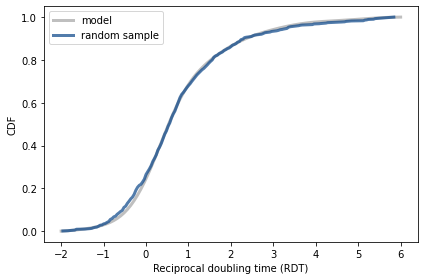

In [49]:
cdf_sample = Cdf.from_seq(sample)

cdf_rdt.plot(label='model', color='C5')
cdf_sample.plot(label='random sample', color='C0')

decorate(xlabel='Reciprocal doubling time (RDT)',
         ylabel='CDF')

## Simulation with Correlation

Recall that `simulate_growth` takes a generator as an argument, so it is easy to run the simulations with the correlated generator.

In [50]:
np.random.seed(22)

In [51]:
rdt_gen = correlated_generator(cdf_rdt, 0.5)
sims2 = [simulate_growth(rdt_gen)
         for _ in range(101)]

And we can use `interpolate_ages` to extract the distribution of ages for a tumor with a diameter of 16 cm.

In [52]:
diameter = 16
ages = interpolate_ages(sims, diameter)
cdf = Cdf.from_seq(ages)
    
ages2 = interpolate_ages(sims2, diameter)
cdf2 = Cdf.from_seq(ages2)

The following figure shows the distribution of ages with $\rho=0$ and $\rho=0.5$.

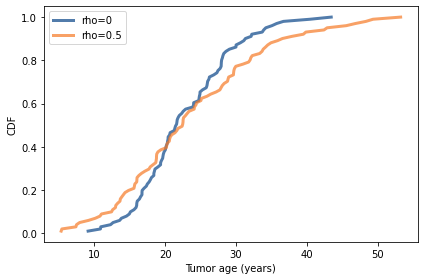

In [53]:
cdf.plot(label='rho=0')
cdf2.plot(label='rho=0.5')
    
decorate(xlabel='Tumor age (years)',
         ylabel='CDF')

Correlation makes the fastest growing tumors faster and the slowest
slower, so the range of ages is wider.
The following table shows the differences between these distributions for several percentiles.

In [54]:
ps = np.array([0.05, 0.25, 0.5, 0.75, 0.95])
df = pd.DataFrame(columns=ps*100)
df.columns.name = 'Percentiles'
df.index.name = 'Correlation'

df.loc[0] = cdf.quantile(ps)
df.loc[0.5] = cdf2.quantile(ps)
df

Percentiles,5.0,25.0,50.0,75.0,95.0
Correlation,,,,,
0.0,13.557751,18.048221,21.601211,27.438600,34.200925
0.5,9.155178,16.015247,22.466764,29.689567,42.857344


The difference is modest for low
percentiles, but for the 95th percentile it is more than 8 years. 

These differences show that serial correlation has a substantial effect on the results.
So if we need to compute these distribution precisely, we would need a better estimate of the actual serial correlation.

However, this model is sufficient to answer the question we started
with: given a tumor with a linear dimension of 15.5 cm, what is the
probability that it formed more than 9 years ago?

With no serial correlation, the probability is roughly 99.9%, or almost certain. 
With correlation 0.5, faster-growing tumors are more likely, but the probability is still about 99%.

Another likely source of error is the assumption that tumors are
approximately spherical. For a tumor with linear dimensions 15.5 x 15
cm, this assumption is probably not valid. If, as seems likely, a tumor this size is relatively flat, it might have the same volume as a 6 cm sphere. 
With this smaller volume and correlation 0.5, the probability the age of the tumor is greater than 9 years is still 95%.

So even taking into account modeling errors, it is unlikely that such a large tumor could have formed less than 9 years prior to the date of
diagnosis.

## Approximate Bayesian Calculation

At this point you might wonder why this example is in a book about Bayesian statistics.
We never defined a prior distribution or did a Bayesian update.
Why not?

Because we didn't have to.
Instead we used simulations to compute ages and sizes for a collection of hypothetical tumors.
Then, implicitly, we used the simulation results to form a joint distribution of age and size.

If we select a column from the joint distribution, we get a distribution of size conditioned on age.
If we select a row, we get a distribution of age conditioned on size.

So this example is like the ones we saw in Chapter 1: if you have all of the data, you don't need Bayes's theorem; you can compute probabilities by counting.

This example is a first step toward Approximate Bayesian Computation (ABC).
The next example is a second step.

Zhang et al, Distribution of Renal Tumor Growth Rates Determined
    by Using Serial Volumetric CT Measurements, January 2009
    *Radiology*, 250, 137-144.
    
https://pubs.rsna.org/doi/full/10.1148/radiol.2501071712

## Counting Cells

This example comes from Cameron Davidson-Pilon, who also provides the Space Shuttle problem in Chapter xxx.

In [this blog post](https://dataorigami.net/blogs/napkin-folding/bayesian-cell-counting), Davidson-Pilon builds a model of the process biologists use to estimate the concentration of cells, or other discrete elements, in a sample of liquid.

The example he presents is counting cells in a "yeast slurry", which is a mixture of yeast and water used in brewing beer.

There are two steps in the process:

* First, the slurry is diluted until the concentration is low enough that it is practical to count cells.

* Then a small sample is put on a hemocytometer, which is a specialized slide that holds a fixed amount of liquid above a rectangular grid etched in the glass.

The cells and the grid are visible in a microscope, making it easy to count the cells accurately.

As an example, suppose we start with a yeast slurry with unknown concentration of cells.

Starting with a 1 mL sample, we will dilute it by adding it to a shaker with 9 mL of water and mixing well.
Then we'll dilute it again, and then a third time.
Each dilution reduces the concentration by a factor of 10, so three dilutions reduces the concentration by a factor of 1000.

Then we add the diluted sample to the hemocytometer, which has a capacity of 0.0001 mL spread over a 5x5 grid.

Although the grid has 25 squares, it is standard practice to inspect only a few of them, say five, and report the total number of cells in the inspected squares. 

This process is simple enough, but at every stage there are sources of error:

* During the dilution process, liquids are measured using pipettes that introduce measurement error.

* The amount of liquid in the hemocytometer might vary from sample to sample.

* During each step of the sampling process, we might select more or less than the average number of cells, due to random variation.

Davidson-Pilon presents a PyMC model that describes these errors.
I'll start by replicating his model; then we'll adapt it for ABC.

Suppose there are 25 squares in the grid, we count 5 of them, and the total number of cells is 49.

In [55]:
total_squares = 25
squares_counted = 5
yeast_counted = 49

Here's the first part of the model, which defines the prior distribution of `yeast_conc`, which is the concentration of yeast we're trying to estimate.

`shaker1_vol` is the actual volume of water in the first shaker, which should be 9 mL, but might be higher or lower, with standard deviation 0.05 mL.

`shaker2_vol` and `shaker3_vol` are the volumes in the second and third shakers.

In [56]:
import pymc3 as pm
billion = 1e9

with pm.Model() as model:
    yeast_conc = pm.Normal("yeast conc", 
                           mu=2 * billion, sd=0.4 * billion)

    shaker1_vol = pm.Normal("shaker1 vol", 
                               mu=9.0, sd=0.05)
    shaker2_vol = pm.Normal("shaker2 vol", 
                               mu=9.0, sd=0.05)
    shaker3_vol = pm.Normal("shaker3 vol", 
                               mu=9.0, sd=0.05)

Now, the sample we draw from the yeast slurry is supposed to be 1 mL, but might be more or less.
And similarly for the sample we draw from the first shaker and from the second shaker.

The following variables model these samples.

In [57]:
with model:
    yeast_slurry_vol = pm.Normal("yeast slurry vol",
                                    mu=1.0, sd=0.01)
    shaker1_to_shaker2_vol = pm.Normal("shaker1 to shaker2",
                                    mu=1.0, sd=0.01)
    shaker2_to_shaker3_vol = pm.Normal("shaker2 to shaker3",
                                    mu=1.0, sd=0.01)

Given the actual volumes in the samples and in the shakers, we can compute the effective dilution, `final_dilution`, which should be approximately 1000, but might be higher or lower.

In [58]:
with model:
    dilution_shaker1 = (yeast_slurry_vol       / 
                        (yeast_slurry_vol + shaker1_vol))
    dilution_shaker2 = (shaker1_to_shaker2_vol / 
                        (shaker1_to_shaker2_vol + shaker2_vol))
    dilution_shaker3 = (shaker2_to_shaker3_vol / 
                        (shaker2_to_shaker3_vol + shaker3_vol))
    
    final_dilution = (dilution_shaker1 * 
                      dilution_shaker2 * 
                      dilution_shaker3)

The next step is to place a sample from the third shaker in the chamber of the hemocytomer.
The capacity of the chamber should be 0.0001 mL, but might vary; to describe this variance, we'll use a gamma distribution, which ensures that we don't generate negative values.

In [59]:
with model:
    chamber_vol = pm.Gamma("chamber_vol", 
                           mu=0.0001, sd=0.0001 / 20)

On average, the number of cells in the chamber is the product of the actual concentration, final dilution, and chamber volume.
But the actual number might vary; we'll use a Poisson distribution to model this variance.

In [60]:
with model:
    yeast_in_chamber = pm.Poisson("yeast in chamber", 
        mu=yeast_conc * final_dilution * chamber_vol)

Finally, each cell in the chamber might be in one of the squares we count, with probability `p=squares_counted/total_squares`.
So the actual count follows a binomial distribution.

In [61]:
with model:
    count = pm.Binomial("count", 
        n=yeast_in_chamber, 
        p=squares_counted/total_squares,
        observed=yeast_counted)

With the model specified, we can use `sample` to generate a sample from the posterior distribution.

In [62]:
with model:
    trace = pm.sample(1000, return_inferencedata=False)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [chamber_vol, shaker2 to shaker3, shaker1 to shaker2, yeast slurry vol, shaker3 vol, shaker2 vol, shaker1 vol, yeast conc]
>Metropolis: [yeast in chamber]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [63]:
posterior_sample = trace['yeast conc'] / billion
cdf_pymc = Cdf.from_seq(posterior_sample)
print(cdf_pymc.mean(), cdf_pymc.credible_interval(0.9))

2.280586336273483 [1.81533604 2.74310193]


So far we've been following in Davidson-Pilon's steps.
And for this problem, the solution using PyMC is sufficient.
But it also provides an opportunity to demonstrate ABC.

The fundamental idea of ABC is that we use the prior distribution to generate a sample of the parameters, and then simulate the system for each set of parameters in the sample.

In this case, since we already have a PyMC model, we can use `sample_prior_predictive` to do the sampling and the simulation.

In [64]:
with model:
    prior_sample = pm.sample_prior_predictive(10000)

The result is a dictionary that contains samples from the prior distribution of the parameters and the prior predictive distribution of count.

In [65]:
count = prior_sample['count']
print(count.mean())

40.1451


Now, to generate a sample from the posterior distribution, we'll select only the elements in the prior sample where `count` equals the observed data, 49.

In [66]:
mask = (count == 49)
mask.sum()

246

If we select only the samples that yield the observed data, the result is a sample from the posterior distribution of the parameter.
Of course, the parameter we are most interested in is the yeast concentration.

In [67]:
posterior_sample2 = prior_sample['yeast conc'][mask] / billion
print(posterior_sample2.mean())

2.2712069604587914


In [68]:
cdf_abc = Cdf.from_seq(posterior_sample2)

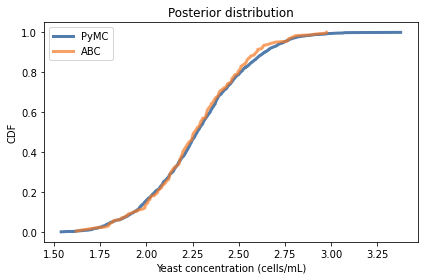

In [69]:
cdf_pymc.plot(label='PyMC')
cdf_abc.plot(label='ABC')

decorate(xlabel='Yeast concentration (cells/mL)',
         ylabel='CDF',
         title='Posterior distribution')

## When do we get to the approximate part?

In [77]:
n = prior_sample['yeast in chamber']
p = squares_counted/total_squares
n, p

(array([113, 182, 153, ..., 125, 201, 198]), 0.2)

In [78]:
from scipy.stats import binom

weights = binom(n, p).pmf(yeast_counted).flatten()
weights.shape

(10000,)

In [84]:
np.isnan(weights).sum()

0

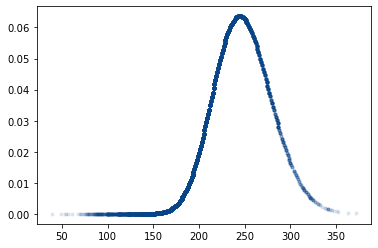

In [79]:
plt.plot(n, weights, '.', alpha=0.1)

In [80]:
from scipy.stats import gaussian_kde

qs = prior_sample['yeast conc'] / billion
ps = weights

posterior_pmf = Pmf(ps, qs)
posterior_pmf.normalize()
posterior_pmf.mean()

2.2712644108955566

In [81]:
cdf_abc2 = posterior_pmf.make_cdf()

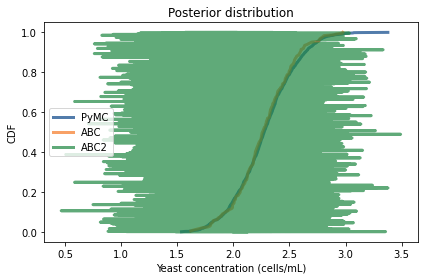

In [82]:
cdf_pymc.plot(label='PyMC')
cdf_abc.plot(label='ABC')
cdf_abc2.plot(label='ABC2')

decorate(xlabel='Yeast concentration (cells/mL)',
         ylabel='CDF',
         title='Posterior distribution')

## Exercises

**Exercise:** This exercise is based on [a blog post by Rasmus Bååth](http://www.sumsar.net/blog/2014/10/tiny-data-and-the-socks-of-karl-broman), which is motivates by a tweet from Karl Broman, who wrote:

> That the first 11 socks in the laundry are distinct suggests that there are a lot of socks.

Suppose you pull 11 socks out of the laundry and find that no two of them make a matched pair.  Estimate the number of socks in the laundry.

To solve this problem, we'll use the model Bååth suggests, which is based on these assumptions:

* The laundry contains some number of pairs of socks, `n_pairs`, plus some number of unpaired socks, `n_odds`.

* The pairs of socks are different from each other and different from the unpaired socks; in other words, the number of socks of each type is either 1 or 2, never more.

We'll also use the prior distributions Bååth suggests, which are:

* The number of socks follow a negative binomial distribution with mean 30 and standard deviation 15.

* The proportion of socks that are paired is from a beta distribution with parameters `alpha=15` and `beta=2`.

To get you started, I'll define the priors.

In [ ]:
from scipy.stats import nbinom, beta

mu = 30
p = 0.8666666
r = mu * (1-p) / p

prior_n_socks = nbinom(r, 1-p)
prior_n_socks.mean(), prior_n_socks.std()

In [ ]:
prior_prop_pair = beta(15, 2)
prior_prop_pair.mean()

In [ ]:
qs = np.arange(90)
ps = prior_n_socks.pmf(qs)
pmf = Pmf(ps, qs)
pmf.normalize()

pmf.plot(label='prior', drawstyle='steps')

decorate(xlabel='Number of socks',
         ylabel='PMF')

In [ ]:
from utils import pmf_from_dist

qs = np.linspace(0, 1, 101)
pmf = pmf_from_dist(prior_prop_pair, qs)
pmf.plot(label='prior', color='C1')

decorate(xlabel='Proportion of socks in pairs',
         ylabel='PDF')

We can sample from the prior distributions like this:

In [ ]:
n_socks = prior_n_socks.rvs()
prop_pairs = prior_prop_pair.rvs()

n_socks, prop_pairs

And use the values to compute `n_pairs` and `n_odds`:

In [ ]:
n_pairs = np.round(n_socks//2 * prop_pairs)
n_odds = n_socks - n_pairs*2

n_pairs, n_odds

Now you can take it from there.

In [ ]:
# Solution

n_pairs = 9
n_odds = 5

socks = np.append(np.arange(n_pairs), 
                  np.arange(n_pairs + n_odds))

print(socks)

In [ ]:
# Solution

picked_socks = np.random.choice(socks, size=11, replace=False)
picked_socks

In [ ]:
# Solution

values, counts = np.unique(picked_socks, return_counts=True)
values

In [ ]:
# Solution

counts

In [ ]:
# Solution

solo = np.sum(counts==1)
pairs = np.sum(counts==2)

solo, pairs

In [ ]:
# Solution

def pick_socks(n_pairs, n_odds, n_pick):
    socks = np.append(np.arange(n_pairs), 
                      np.arange(n_pairs + n_odds))
    
    picked_socks = np.random.choice(socks, 
                                    size=n_pick, 
                                    replace=False)
    
    values, counts = np.unique(picked_socks, 
                               return_counts=True)
    pairs = np.sum(counts==2)
    odds = np.sum(counts==1)
    return pairs, odds

In [ ]:
# Solution

pick_socks(n_pairs, n_odds, 11)

In [ ]:
# Solution

data = (0, 11)
res = []
for i in range(10000):
    n_socks = prior_n_socks.rvs()
    if n_socks < 11:
        continue
    prop_pairs = prior_prop_pair.rvs()
    n_pairs = np.round(n_socks//2 * prop_pairs)
    n_odds = n_socks - n_pairs*2
    result = pick_socks(n_pairs, n_odds, 11)
    if result == data:
        res.append((n_socks, n_pairs, n_odds))

len(res)

In [ ]:
# Solution

columns = ['n_socks', 'n_pairs', 'n_odds']
results = pd.DataFrame(res, columns=columns)
results.head()

In [ ]:
# Solution

len(results)

In [ ]:
# Solution

qs = np.arange(15, 100)
posterior_n_socks = Pmf.from_seq(results['n_socks'])
print(posterior_n_socks.median(),
      posterior_n_socks.credible_interval(0.9))

In [ ]:
# Solution

posterior_n_socks.plot(label='posterior', drawstyle='steps')

decorate(xlabel='Number of socks',
         ylabel='PMF')